# Energy-Based models and structured prediction

This notebook works with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

We tackle this problem by implementing a dynamic programming algorithm to align the text image with the predictions. We also compare our solution to GTN framework.

# Resources

GTN framework has support for finding Viterbi paths and training the prediction. The links included below are helpful for understanding how GTN works\:
- [CTC](https://distill.pub/2017/ctc/)
- [Weighted Automata in ML](https://awnihannun.com/writing/automata_ml/automata_in_machine_learning.pdf)

Additional Links\:
- [GTN](https://github.com/gtn-org/gtn)
- [GTN Documentation](https://gtn.readthedocs.io/en/latest/)
- [GTN Applications](https://github.com/facebookresearch/gtn_applications)

In [ ]:
!pip install gtn==0.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset
We create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [ ]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

mkdir: cannot create directory ‘fonts’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0  21660      0  0:00:01  0:00:01 --:--:-- 21644
Archive:  fonts/font.zip


torch.Size([32, 18])


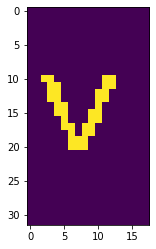

In [ ]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import gtn

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(), 
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise
  
  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text
  
  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1 
    
    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)
        

    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img = next(iter(sds))[0]
print(img.shape)
plt.imshow(img)

We can look at what the entire alphabet looks like in this dataset.

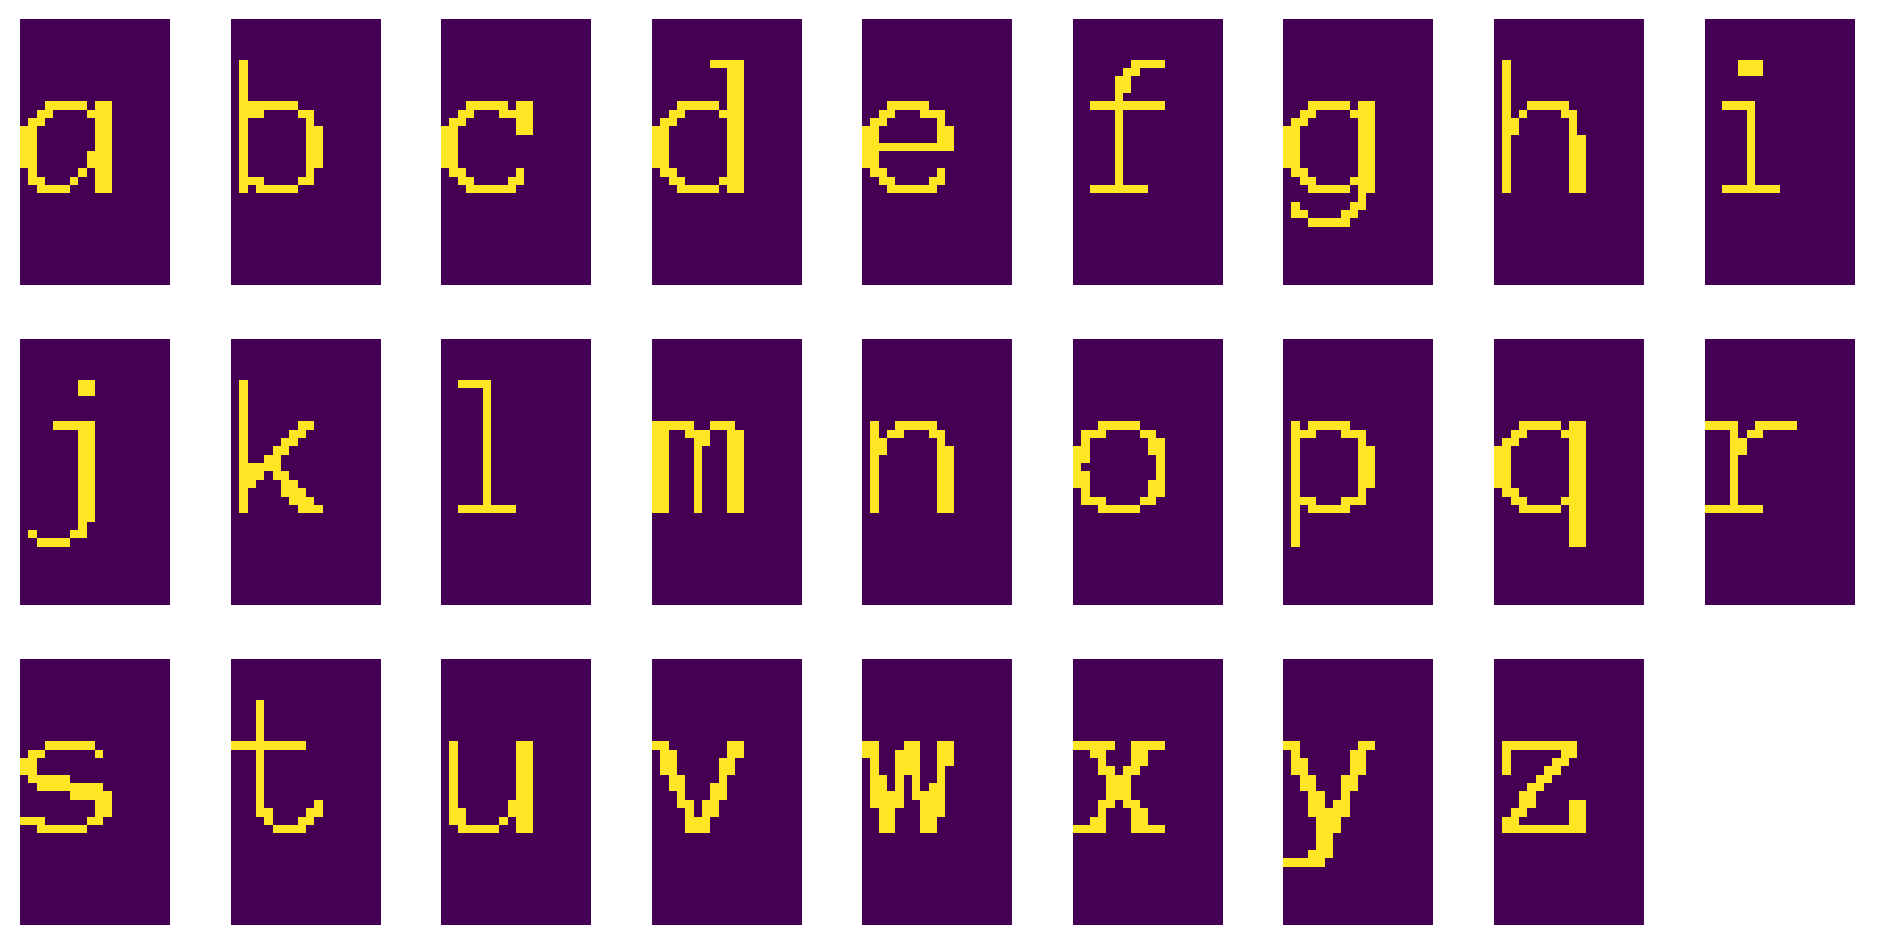

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')
    
plt.show()

We can also put the entire alphabet in one image.

(-0.5, 339.5, 31.5, -0.5)

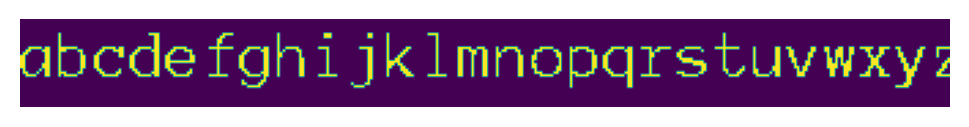

In [ ]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things. 
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

In [ ]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [ ]:
from torch import nn

class SimpleNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d((2,3), stride=(2,1))

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv4 = nn.Conv2d(32, 27, kernel_size=4)


    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out[:, :, 0, :].permute(0, 2, 1)
        

Let's initalize the model and apply it to the alphabet image:

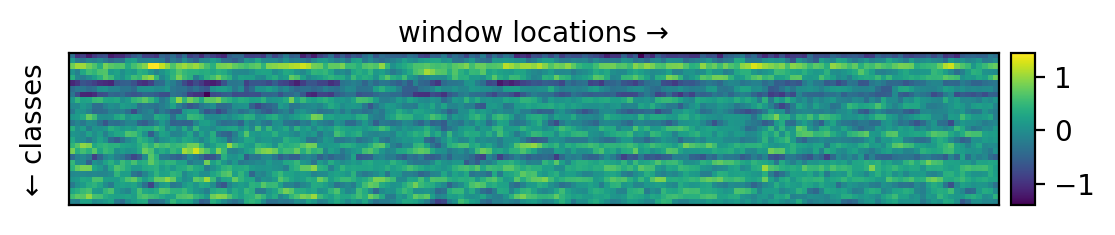

In [ ]:
model = SimpleNet()
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax) 
    
plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [ ]:
def train_model(model, epochs, dataloader, criterion, optimizer):
    for epoch in range(1, epochs+1):
        epoch_loss = 0

        for batch in tqdm(dataloader):
            X, y = batch[0].unsqueeze(dim=1).float(), batch[1]
            X, y = X.to(device), y.to(device)

            y_pred = model(X)[:,0,:]

            loss = criterion(y_pred, y)

            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss/BATCH_SIZE

        print(f'[EPOCH]: {epoch}, [LOSS]: {avg_loss}')



In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim

BATCH_SIZE = 16

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=simple_collate_fn)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# initialize optimizer
optimiser = torch.optim.SGD(model.parameters(), lr=0.01)

# train the model on the one-character dataset
train_model(model, 30, dataloader, cross_entropy, optimiser)


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 1, [LOSS]: 10.63217705488205


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 2, [LOSS]: 5.510320223867893


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 3, [LOSS]: 2.847362706437707


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 4, [LOSS]: 1.6719264080747962


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 5, [LOSS]: 1.0671552633866668


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 6, [LOSS]: 0.8211762066930532


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 7, [LOSS]: 0.6998908240348101


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 8, [LOSS]: 0.4892956535331905


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 9, [LOSS]: 0.4413091514725238


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 10, [LOSS]: 0.37941374350339174


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 11, [LOSS]: 0.33651321241632104


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 12, [LOSS]: 0.3099225424230099


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 13, [LOSS]: 0.2464832797413692


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 14, [LOSS]: 0.22027076355880126


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 15, [LOSS]: 0.1923115854151547


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 16, [LOSS]: 0.18200309696840122


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 17, [LOSS]: 0.16419248329475522


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 18, [LOSS]: 0.14518089243210852


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 19, [LOSS]: 0.11858524777926505


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 20, [LOSS]: 0.08888081507757306


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 21, [LOSS]: 0.11942540912423283


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 22, [LOSS]: 0.10622043331386521


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 23, [LOSS]: 0.07198974618222564


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 24, [LOSS]: 0.07582985280896537


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 25, [LOSS]: 0.0720225176482927


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 26, [LOSS]: 0.05962510299286805


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 27, [LOSS]: 0.0730763477331493


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 28, [LOSS]: 0.054533069021999836


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 29, [LOSS]: 0.05425155724515207


  0%|          | 0/63 [00:00<?, ?it/s]

[EPOCH]: 30, [LOSS]: 0.05223319018841721


In [ ]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)
        
tds = SimpleWordsDataset(1, len=100)
assert get_accuracy(model, tds) == 1.0, 'Make sure model is achieving 100% accuracy for 1 character'

Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

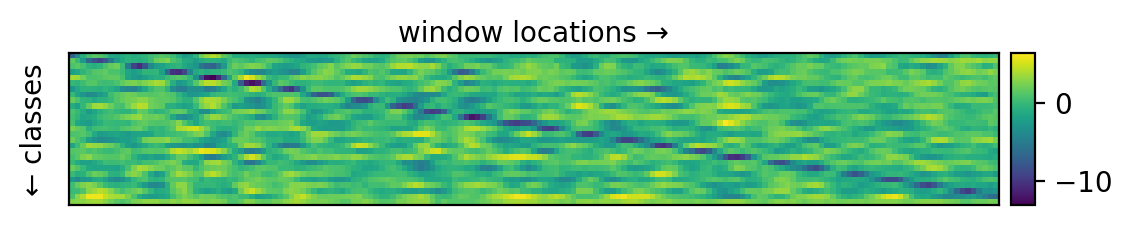

In [ ]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())

We can see that the model is recognizing the letters a-z, shown by the purple regions of low energy at equal intervals across the diagonal on the chart. To be able to capture whole words, the model would also need to learn the space between letters, to be able to link letters together to form whole words.

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, we write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [ ]:
def build_path_matrix(energies, targets):
    # inputs: 
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    
    L = energies.shape[1]
    targets = targets.unsqueeze(dim=1)
    targets = targets.repeat(1, L, 1)
    path_matrix = torch.gather(energies, 2, targets)
    return path_matrix

def build_ce_matrix(energies, targets):
    # inputs: 
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \ververtt = targets.unsqueeze(1).repeat(1,energies.shape[1],1)t l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])

    energies, targets = energies.to(device), targets.to(device)
    batch_size = energies.shape[0]
    L = energies.shape[1]
    T = targets.shape[1]
    energies = energies.repeat(1, T, 1)
    energies = energies.view(-1, 27)
    targets = targets.repeat_interleave(L, dim=1)
    targets = targets.flatten()
    cross_entropy_matrix = cross_entropy(energies, targets, reduction='none')
    cross_entropy_matrix = cross_entropy_matrix.view(batch_size, T, L).permute(0, 2, 1)
    return cross_entropy_matrix

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '\_' models the separation between words, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc). 
We implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [ ]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)

    transformed = torch.tensor([ord(c) - ord('a') if c != '_' else 26 for c in '_'.join(list(s))])
    return transformed

Now, let's plot energy table built on our model's prediction for alphabet image.

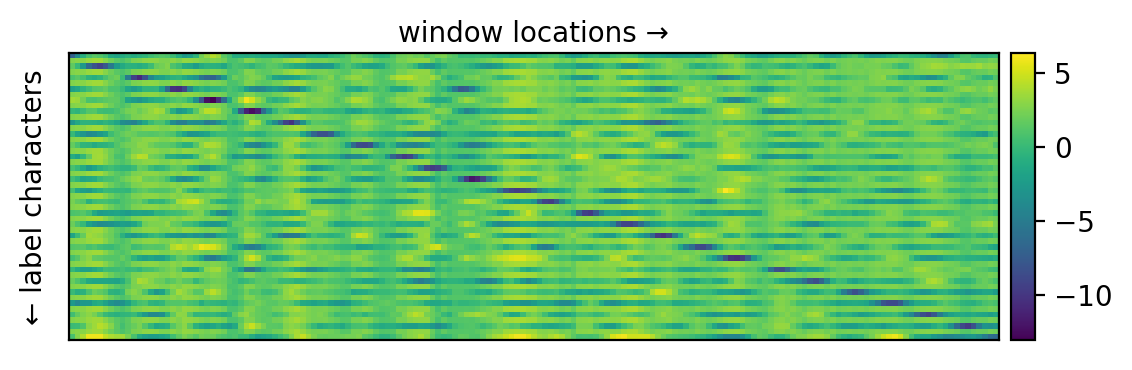

In [ ]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax) 

energies = model(alphabet.to(device).view(1, 1, *alphabet.shape))
targets = transform_word(string.ascii_lowercase).unsqueeze(0).to(device)

pm = build_path_matrix(energies, targets)
plot_pm(pm[0].detach())

The model is able to correctly classify the individual letters, shown by the dark purple regions of low energy. The blue regions across the chart show that some other spaces in the energy landscape are also being given low energy, There are some significant yellow regions which signify areas of high energy - these may correspond to specific letter/location combinations that are incompatible in our data.

Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. The trajectory starts at the top-left corner of the chart, and ends at the bottom-right corner. The trajectory must also follow a non-increasing slope, meaning that as the window location increases the label character must stay the same or decrease. An optimal trajectory would pass through all dark purple regions of low energy. This would mean that the sum of energies along the trajectory would be minimized, which gives us our best $z$. Therefore the optimal trajectory would closely follow the diagonal.

We implement a function that would tell us the energy of a particular path (i.e. pairing).

In [ ]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies 
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    
    energy = 0.0
    current = path[0]

    for i, point in enumerate(path):
        if point < current:
            # mapping is invalid, return 2**30
            return torch.tensor(2**30)
        if i >= pm.size()[0]:
            # mapping is invalid, return 2**30
            return torch.tensor(2**30)
        energy += pm[i][point]
        current = point
    
    return energy

Now we can check some randomly generated paths and see the associated energies for our alphabet image:

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 20, 21, 21, 22, 23, 24, 24, 25, 26, 26, 26, 26, 26, 26, 27, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 34, 35, 35, 35, 36, 36, 37, 37, 38, 39, 40, 40, 40, 40, 40, 40, 41, 41, 41, 42, 43, 43, 44, 44, 44, 45, 45, 46, 46, 46, 46, 47, 47, 47, 48, 48, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50]
energy is 78.01206970214844


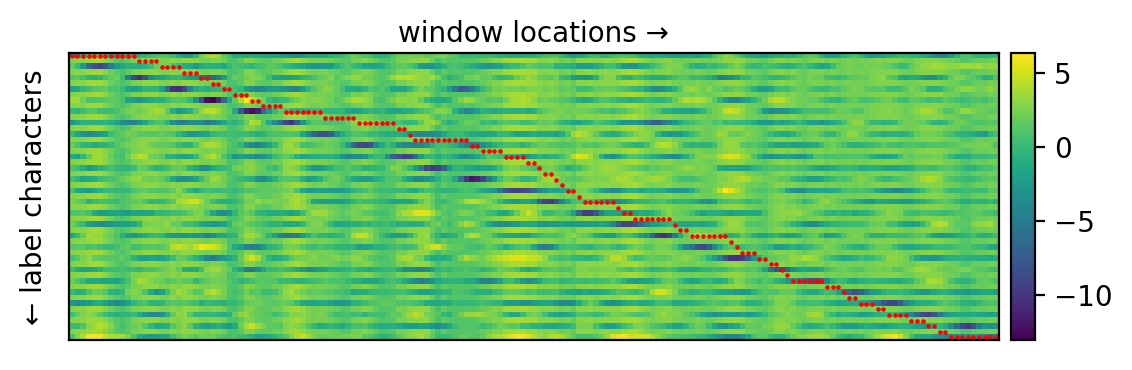

In [ ]:
path = torch.zeros(energies.shape[1] - 1)
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))

points = list(zip(range(energies.shape[1]), path))
plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

We also generate two paths with bad energies, print their energies and plot them.

energy is 1073741824


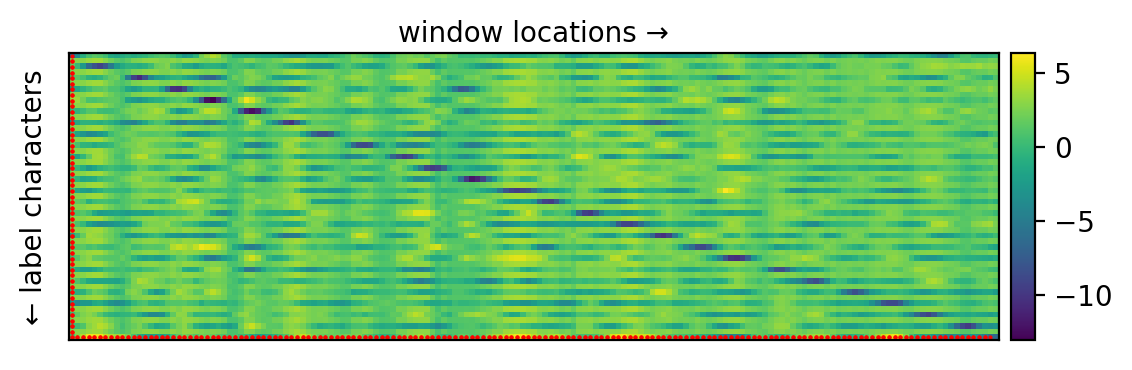

In [ ]:
bad_path1 = []
bad_points1 = []
i = 0
while (i < targets.shape[1] - 1):
    bad_path1.append(i)
    bad_points1.append((0,i))
    i += 1

j = 0
while (j < energies.shape[1] - 1):
    bad_path1.append(targets.shape[1] - 1)
    bad_points1.append((j, targets.shape[1] - 1))
    j += 1

plot_pm(pm[0].detach(), bad_points1)
print('energy is', path_energy(pm[0], bad_path1).item())

energy is 1073741824


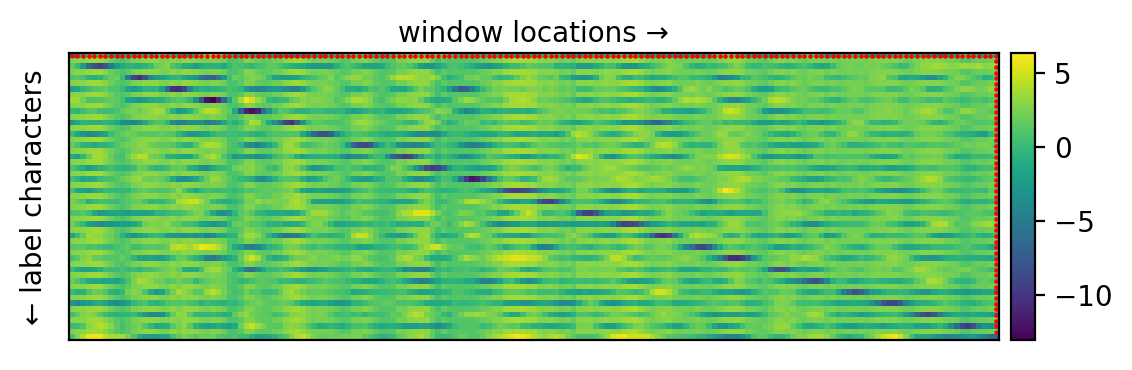

In [ ]:
bad_path2 = []
bad_points2 = []
j = 0
while (j < energies.shape[1] - 1):
    bad_path2.append(0)
    bad_points2.append((j, 0))
    j += 1

i = 0
while (i < targets.shape[1] - 1):
    bad_path2.append(i)
    bad_points2.append((energies.shape[1] - 1,i))
    i += 1

plot_pm(pm[0].detach(), bad_points2)
print('energy is', path_energy(pm[0], bad_path2).item())

## Part - 1\: Viterbi

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

In [ ]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix 
    #         3. the dp array

    pm = pm.to(device)
    L, T = pm.shape[0], pm.shape[1]

    dp = torch.ones_like(pm)*(2**30)

    best_path = []

    cell_sources = torch.zeros(L, T, 2).type(torch.int)
  
    for i in range(L):
        for j in range(T):
            if i >= j:
                cell_cost = pm[i, j]

                if (i*j == 0) and (cell_cost < dp[i, j]):
                    dp[i, j], cell_sources[i, j] = cell_cost, torch.tensor([-1, -1])

                if (i >= 1) and (dp[i, j] > (cell_cost + dp[i-1, j])):
                    dp[i, j], cell_sources[i, j] = (cell_cost + dp[i-1, j]), torch.tensor([i-1, j])

                if (i*j > 0) and (dp[i, j] > (cell_cost + dp[i-1, j-1])):
                    dp[i, j], cell_sources[i, j] = (cell_cost + dp[i-1, j-1]), torch.tensor([i-1, j-1])
 
    i, j = L-1, T-1
    
    while (i > -1 and j > -1):
        current_cell = cell_sources[i, j]
        i_source = current_cell[0].item()
        j_source = current_cell[1].item()

        best_path.append((i, j))

        i = i_source
        j = j_source
    
    best_path.reverse()
    
    return dp[L-1, T-1], best_path, dp

Let's take a look at the best path:

free energy is -948.6358032226562


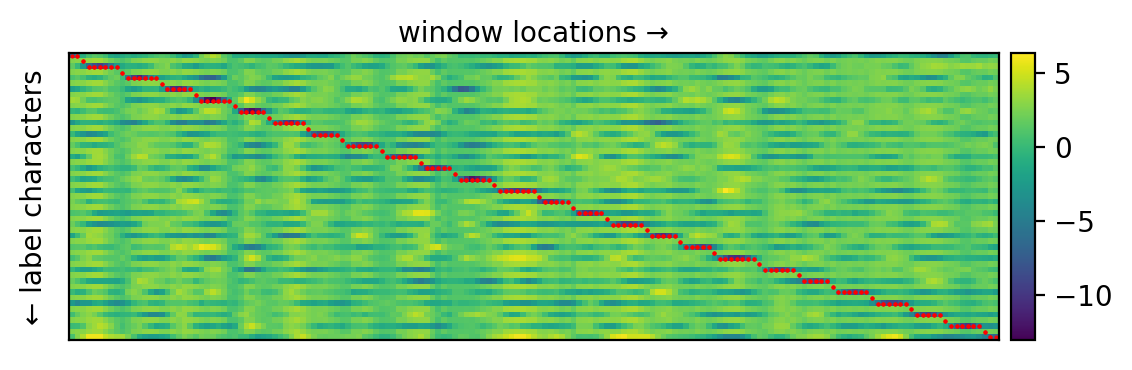

In [ ]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

We can also visualize the dp array.

(-0.5, 164.5, 50.5, -0.5)

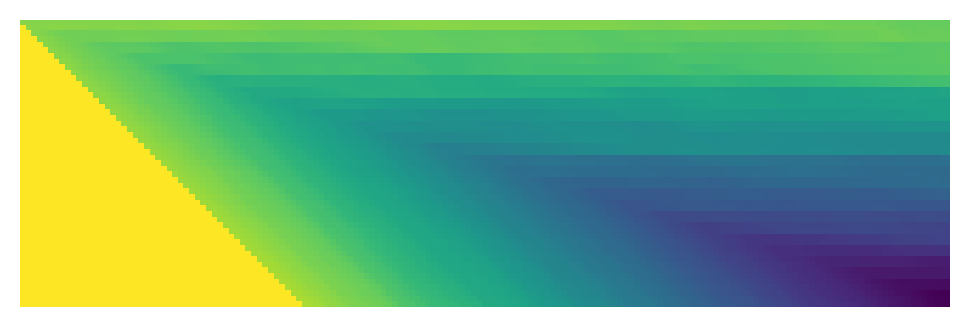

In [ ]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(torch.min(d).item(), 200))
plt.axis('off')

### Training loop
Now we can train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [ ]:
def train_ebm_model(model, num_epochs, train_loader, criterion, optimizer):
    ''' Train EBM Model using find_path()'''
    pbar = tqdm(range(num_epochs))
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    model.train()
    for epoch in pbar:
        start_time = time.time()
        # training loop
        for batch in tqdm(dataloader):
            X, y = batch[0].unsqueeze(dim=1).float(), batch[1].repeat_interleave(2, dim=1)
            X, y = X.to(device), y.to(device)
            y[:, [2*i + 1 for i in range(0, batch[1].shape[1])]] = 26

            energy = model(X)
            path_matrix = build_path_matrix(energy, y)
            ce_matrix = build_ce_matrix(energy, y)

            batch_loss = torch.tensor(0.0).to(device)
            for example in range(batch[0].shape[0]):
                total_path_loss = 0.0
                energy_of_best_path, best_path, dp_array = find_path(path_matrix[example])
                
                for i, point in enumerate(best_path):
                    total_path_loss += ce_matrix[example][i][point[1]]
                batch_loss += total_path_loss
            
            average_batch_loss = batch_loss/(batch[0].shape[0])

            optimizer.zero_grad()
            average_batch_loss.backward()
            optimizer.step()

            total_train_loss += average_batch_loss.item()
        
        epoch_time = time.time() - start_time
        pbar.set_postfix({'train_loss': total_train_loss / len(sds), 'Epoch Time': epoch_time})

    return

In [ ]:
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)
    
sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

ebm_model = SimpleNet().to(device)

optimiser = torch.optim.SGD(ebm_model.parameters(), lr=0.01)
train_ebm_model(ebm_model, 10, dataloader, cross_entropy, optimiser)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Let's check what the energy matrix looks like for the alphabet image now.

free energy is -1939.2725830078125


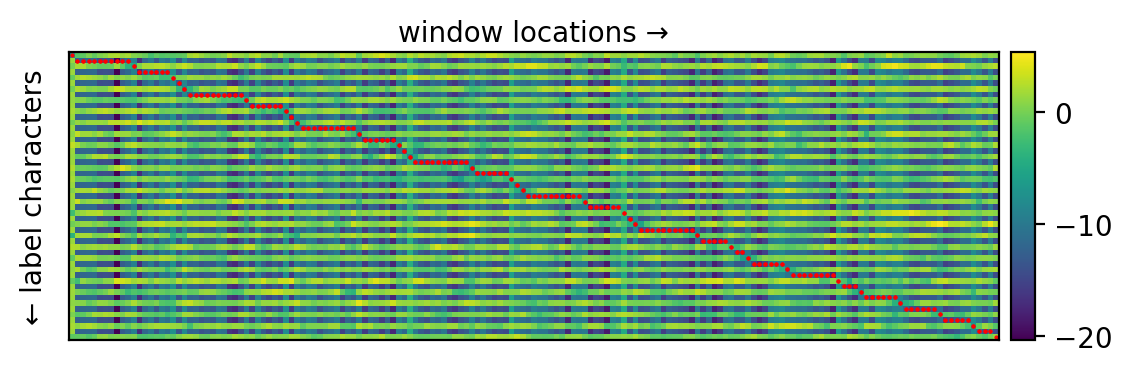

In [ ]:
energies = ebm_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
energies, targets = energies.to(device), targets.to(device)
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

There are many more regions of low energy, because we are working with more characters and the dynamic programming algorithm gives us multiple good paths (and local optima) to take. Overall the free energy is lower for the multi-character learned network, since the optimal trajectory can pass through more dark purple, low energy regions.

We visualise the raw energies output:

(-0.5, 164.5, 26.5, -0.5)

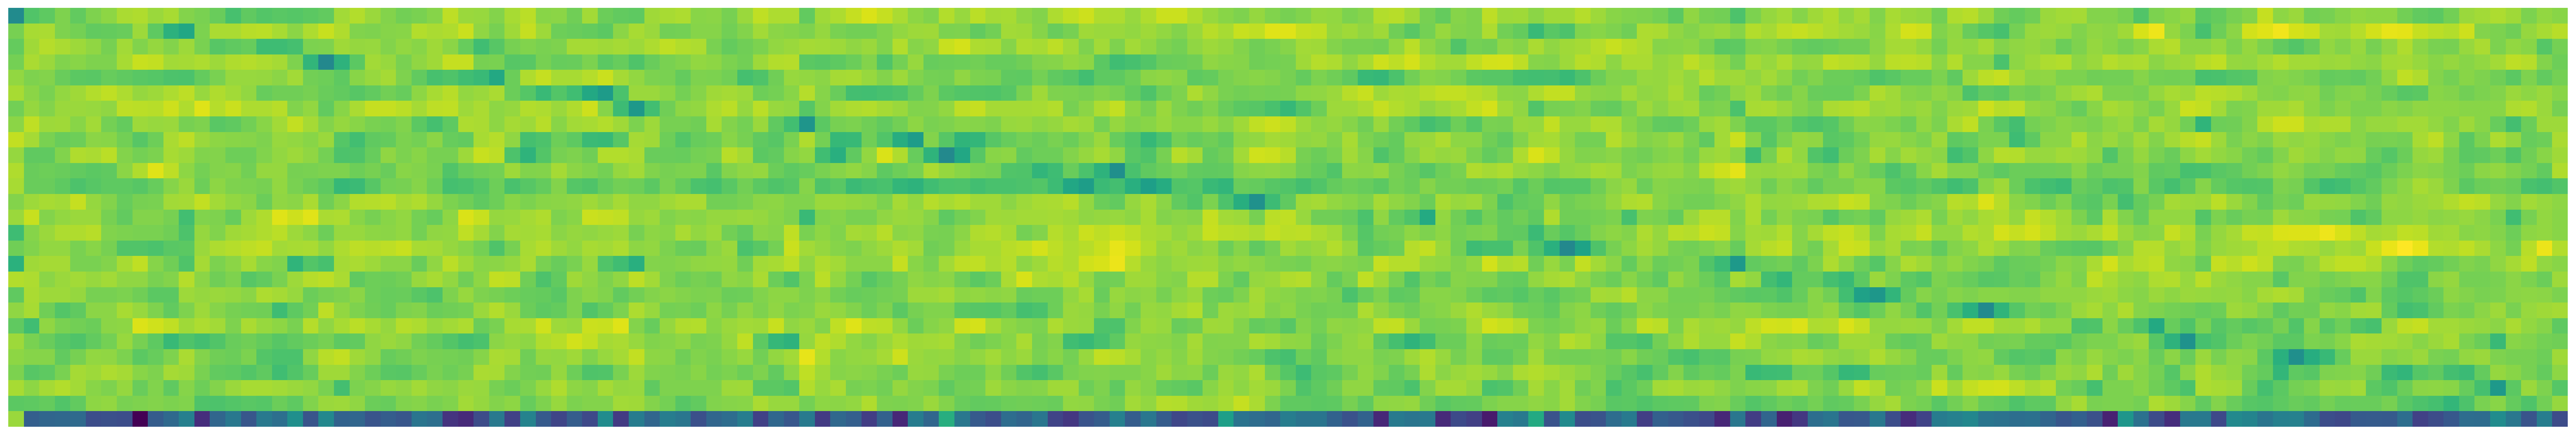

In [ ]:
alphabet_energy_post_train_viterbi = ebm_model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

After training only on the one-character dataset we saw a more pronounced low energy diagonal across the chart. We also didn't see a dark purple, low energy line going across the bottom of the chart, which we see now for the multi-character case.

## Decoding

Now we can use the model for decoding a word from an image. We pick some word, apply the model to it, and see energies. 

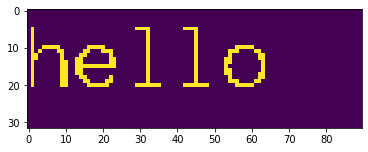

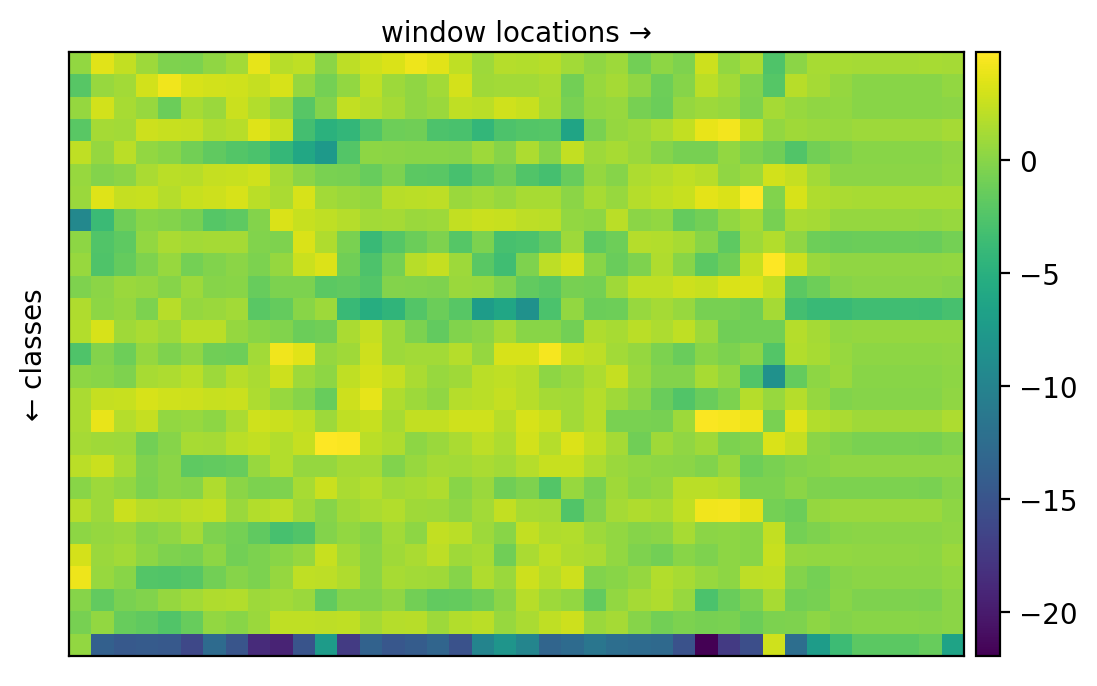

In [ ]:
img = sds.draw_text('hello')
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

We can see that some characters light up. Now we implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [1]:
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string
    
    return "".join([max(s, key=lambda c: s.count(c)) for s in "".join([chr(i + ord('a')) if i != 26 else " " for i in indices]).split()])

min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello


## Part - 2\: GTN

### CTC Loss Function

The below cells implement the CTC Loss function, which will be needed for the training, and the Viterbi algorithm.

- For calculating loss, `CTCLoss()` can be used.
- For viterbi, `CTCLossFunction.viterbi()` can be used.

### Brief Explanation\:

GTN constructs 2 graphs- 
1. Alignment graph $A_y$ that can produce a sequence of any length which when collapsed gives the output.
2. Emission graph $\mathcal{E}$ that can produce any sequence of length `L`, input's length. This can be considered as some sort of restriction over $A_y$.

Loss function is then calculated as $-\log P(y \mid X) = -(\log (A_y \circ \mathcal{E}) - \log \mathcal{E})$ where $\circ$ is the composition function.

In [ ]:
# Credits: Adapted from https://github.com/facebookresearch/gtn_applications

class CTCLossFunction(torch.autograd.Function):
    @staticmethod
    def create_ctc_graph(target, blank_idx):
        g_criterion = gtn.Graph(False)
        L = len(target)
        S = 2 * L + 1
        for l in range(S):
            idx = (l - 1) // 2
            g_criterion.add_node(l == 0, l == S - 1 or l == S - 2)
            label = target[idx] if l % 2 else blank_idx
            g_criterion.add_arc(l, l, label)
            if l > 0:
                g_criterion.add_arc(l - 1, l, label)
            if l % 2 and l > 1 and label != target[idx - 1]:
                g_criterion.add_arc(l - 2, l, label)
        g_criterion.arc_sort(False)
        return g_criterion

    @staticmethod
    def forward(ctx, log_probs, targets, blank_idx=0, reduction="none"):
        B, T, C = log_probs.shape
        losses = [None] * B
        scales = [None] * B
        emissions_graphs = [None] * B

        def process(b):
            # create emission graph
            g_emissions = gtn.linear_graph(T, C, log_probs.requires_grad)
            cpu_data = log_probs[b].cpu().contiguous()
            g_emissions.set_weights(cpu_data.data_ptr())

            # create criterion graph
            g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
            # compose the graphs
            g_loss = gtn.negate(
                gtn.forward_score(gtn.intersect(g_emissions, g_criterion))
            )

            scale = 1.0
            if reduction == "mean":
                L = len(targets[b])
                scale = 1.0 / L if L > 0 else scale
            elif reduction != "none":
                raise ValueError("invalid value for reduction '" + str(reduction) + "'")

            # Save for backward:
            losses[b] = g_loss
            scales[b] = scale
            emissions_graphs[b] = g_emissions

        gtn.parallel_for(process, range(B))

        ctx.auxiliary_data = (losses, scales, emissions_graphs, log_probs.shape)
        loss = torch.tensor([losses[b].item() * scales[b] for b in range(B)])
        return torch.mean(loss.cuda() if log_probs.is_cuda else loss)

    @staticmethod
    def backward(ctx, grad_output):
        losses, scales, emissions_graphs, in_shape = ctx.auxiliary_data
        B, T, C = in_shape
        input_grad = torch.empty((B, T, C))

        def process(b):
            gtn.backward(losses[b], False)
            emissions = emissions_graphs[b]
            grad = emissions.grad().weights_to_numpy()
            input_grad[b] = torch.from_numpy(grad).view(1, T, C) * scales[b]

        gtn.parallel_for(process, range(B))

        if grad_output.is_cuda:
            input_grad = input_grad.cuda()
        input_grad *= grad_output / B

        return (
            input_grad,
            None,  # targets
            None,  # blank_idx
            None,  # reduction
        )
    
def viterbi(energies, targets, blank_idx=0):
    outputs = -1 * energies
    B, T, C = outputs.shape
    paths = [None] * B
    scores = [None] * B
    emissions_graphs = [None] * B
    def process(b):
        L = len(targets[b])
        # create emission graph
        g_emissions = gtn.linear_graph(T, C, outputs.requires_grad)
        cpu_data = outputs[b].cpu().contiguous()
        g_emissions.set_weights(cpu_data.data_ptr())

        # create criterion graph
        g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
        g_score = gtn.viterbi_score(gtn.intersect(g_emissions, g_criterion))
        g_path = gtn.viterbi_path(gtn.intersect(g_emissions, g_criterion))
        paths[b] = [2*p if 2*p < L else i for i, p in enumerate(g_path.labels_to_list())]
        l = 0
        paths[b] = []
        for p in g_path.labels_to_list():
            if 2*p < L:
                l = p
                paths[b].append(2*p)
            else:
                paths[b].append(2*l + 1)
        scores[b] = -1 * g_score.item()
        emissions_graphs[b] = g_emissions

    gtn.parallel_for(process, range(B))

    return (scores, paths)

CTCLoss = CTCLossFunction.apply

In [ ]:
def train_gtn_model(model, num_epochs, train_loader, criterion, optimizer):
    ''' Train CTC Model using GTN'''
    pbar = tqdm(range(num_epochs))
    train_losses = []
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    logsoftmax = torch.nn.LogSoftmax(dim=-1)
    max_grad_norm = None
    if torch.cuda.is_available():
        model = model.cuda()
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    for epoch in pbar:
        start_time = time.time()
        for batch in tqdm(train_loader):
            X, y = batch[0].unsqueeze(dim=1).float(), batch[1]
            X, y = X.to(device), y.to(device)

            energy = -model(X)
            energy = logsoftmax(energy)

            batch_loss = criterion(energy, y, 26, "mean")

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            total_train_loss = batch_loss.item()
        
        epoch_time = time.time() - start_time
        train_losses.append(total_train_loss)
        pbar.set_postfix({'train_loss': total_train_loss, 'Epoch Time': epoch_time})

    return

In [ ]:
# Similar to what we have done earlier but instead of find_path(), we will use
# GTN's framework.
sds = SimpleWordsDataset(3, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

model = SimpleNet().to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=0.01)
train_gtn_model(model, 20, dataloader, CTCLoss, optimiser)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

We see that `train_gtn_model()` is faster, because searching the alignment and emission graphs is much faster than iterating through the path matrix we constructed for the previous example.

energy is [-2050.77001953125]


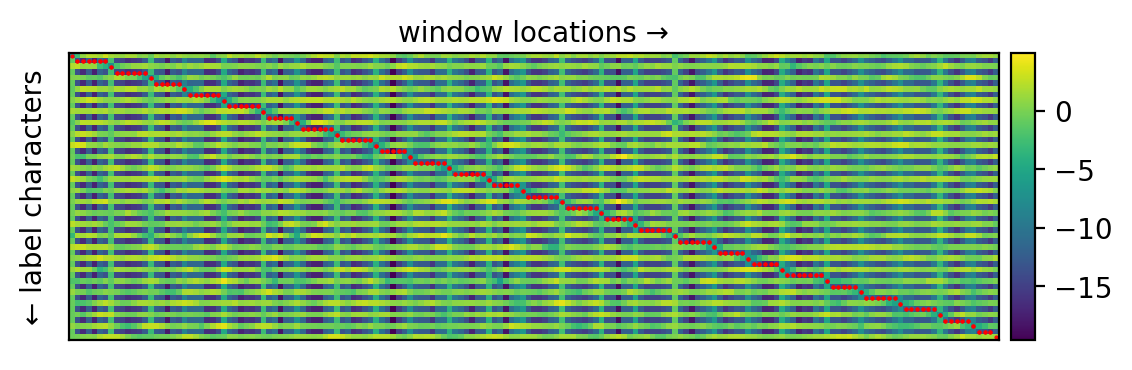

In [ ]:
energies = model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
energies, targets = energies.to(device), targets.to(device)
pm = build_path_matrix(energies, targets.unsqueeze(0))

# We use the provided viterbi function to get score and path
score, paths = viterbi(energies, targets.unsqueeze(dim=0), 26)

path = paths[0]

# path is obtained from the above
points = list(zip(range(energies.shape[1]), path))
plot_pm(pm[0].detach(), points)
print('energy is', score)

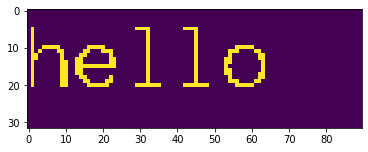

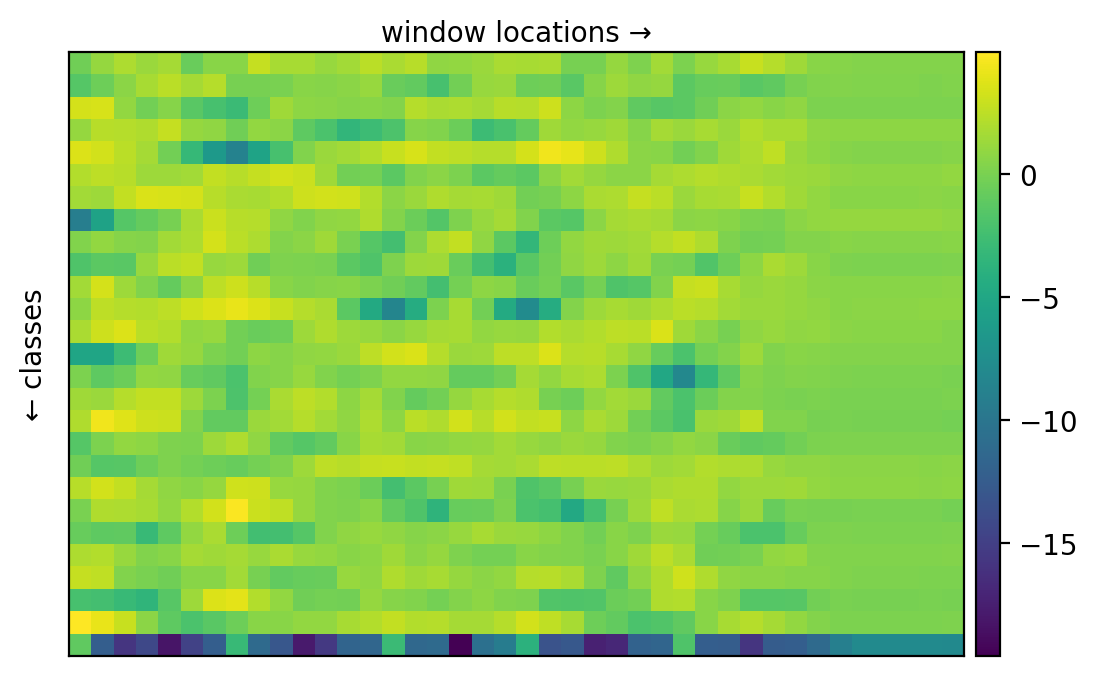

In [ ]:
img = sds.draw_text('hello')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [ ]:
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello
